## Random forest

Random forest is a statistical method used to build a classification model. With this model, one can describe how the values of the target variable is obtained based on the values of the feature variables. Random forest is an ensemble model, which means that is actually built up by numerous base models, and the predicted values are obtained considering prediction from each base model. In this case the base models are decision trees. Each tree is built using random sampling (with replacement) from the sample, and using randomly selected features. 

In the following, the 'Heart Failure Prediction Dataset' is used from kaggle.com : https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

The aim is to describe and predict occurrence of heart failure (=target variable) based on different attributes of the person (=features). 

**The following is included in this project** (https://nbviewer.org/github/MMateo1120/machine_learning_methods/blob/main/random_forest.ipynb):

In [Data preparation](#section1) we will check the dataset for missing values, check the distributions of the variables, and transform variables.

In [Data evaluation I.](#section2) we will investigate the performance of the random forest model **without** hyperparameters tuning. The performance indicator is the predictive accuracy of **repeated hold-out test sets**.

In [Data evaluation II.](#section3) we will investigate the performance of the random forest model **with** hyperparameters tuning. The **k-fold cross-validation** method is used. While this method is appropriate for tuning the hyperparameters, its performance indicator is overoptimistic. 

In [Data evaluation III.](#section4) we will investigate the performance of a decision tree model **with** hyperparameters tuning. The **nested cross-validation** design is used to see the general performance of the model building on our dataset, and use the "best" hyperparameter settings as candidate settings in a (repeated) cross-validation to tune the final model. Also, we perform selection of the relevant independent variables, thus reduce the number of required variables to fit a suitable model.


<a id='section1'></a>

### <ins>Data preparation<ins> 
The details of data preparation can be found at [main/decision_tree.ipynb](https://github.com/MMateo1120/machine_learning_methods/blob/main/decision_tree.ipynb), here only the code is provided:

<a id='asd'></a>
### <ins>Data preparation<ins> 
The details of data preparation can be found at [main/decision_tree.ipynb](https://github.com/MMateo1120/machine_learning_methods/blob/main/decision_tree.ipynb), here only the code is provided:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv(
    "https://raw.githubusercontent.com/MMateo1120/machine_learning_methods/refs/heads/main/heart.csv"
)

features = data.columns[:-1]
target = data.columns[-1]

X = data[features]
y = data[target].to_frame()

# drop rows where cholesterol is outlier:
y = y.loc[X["Cholesterol"] > 0].reset_index(drop=True)
X = X.loc[X["Cholesterol"] > 0].reindex().reset_index(drop=True)

# finding features that are categorical based on the coding of their values:
categorical = []
for column in X.columns:
    if isinstance(X[column][0], str):
        categorical.append(column)
        
# transformation of categorical features:
X["Sex"] = X["Sex"].map({"M": 0, "F": 1})
X["ExerciseAngina"] = X["ExerciseAngina"].map({"N": 0, "Y": 1})

categorical.remove("Sex")
categorical.remove("ExerciseAngina")

onehot_encoder = OneHotEncoder(sparse_output=False)

for column in categorical:
    wide = onehot_encoder.fit_transform(X[column].to_frame())
    wide_df = pd.DataFrame(
        wide, columns=onehot_encoder.get_feature_names_out([column])
    )
    X = X.drop(columns=column)
    X = pd.concat([X, wide_df], axis=1)
    
# y is required to be an array:
y = y.iloc[:,0]

<br/>   <a id='section2'></a>

### <ins>Data evaluation I. : Fitting random forest without tuning the hyperparameters

Generally random forest models are less prune to overfit, and thus may be efficient even without hyperparameter tuning in prediction of unseen datasets. Let's check how well untuned models can predict test sets:

In [2]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

scores = []

np.random.seed(111)

for _ in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf = RandomForestClassifier(random_state=111)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

The distribution of the predictive accuracy of unseen test sets:

(array([ 1.,  1.,  6.,  8., 10., 18., 18., 21., 14.,  3.]),
 array([0.78666667, 0.8       , 0.81333333, 0.82666667, 0.84      ,
        0.85333333, 0.86666667, 0.88      , 0.89333333, 0.90666667,
        0.92      ]),
 <BarContainer object of 10 artists>)

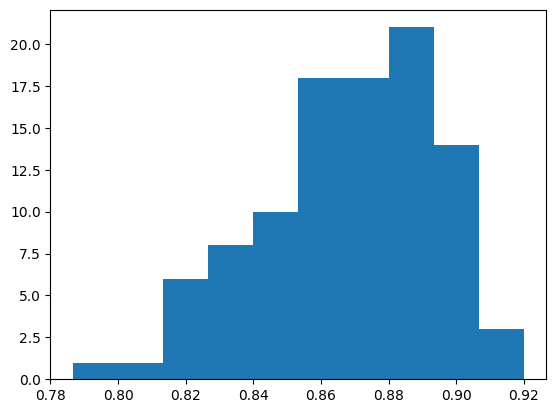

In [3]:
plt.hist(scores)

The statsitics of the predictive accuracy for unseen test sets:

In [4]:
print(f"The mean accuracy: {np.mean(scores)}"
      + "\n"
      + f"The standard deviation: {np.std(scores)}")

The mean accuracy: 0.8656
The standard deviation: 0.02674521764104131


The untuned random forest model performs better than a single decision tree, which had mean predictive accuracy of 0.83.

<br/>   <a id='section3'></a>

### <ins>Data evaluation II. : Tuning hyperparameters using repeated cross-validation

Now let's tune the hyperparameters of the model using 5-times repeated cross-validation with 5 folds:

In [11]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

# suppress warnings from numpy:
np.seterr(all="ignore")

param_grid = {
    "n_estimators": [50, 100, 300, 500],
    "max_features": ["sqrt", None],
    "max_depth": [3, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 10],
}

clf = RandomForestClassifier(random_state=111)
cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=111)

grid_search = GridSearchCV(
    estimator=clf, param_grid=param_grid, cv=cv, n_jobs=-1, 
)

grid_search.fit(X, y)
print(f"The best hyperparameters are: {grid_search.best_params_}")
print(f"The best score is: {grid_search.best_score_}")

The best hyperparameters are: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 500}
The best score is: 0.8691668903803133


Let's use these hyperparameters and see the distribution of the predictive accuracy when different part of the dataset is used as test sets:

(array([ 1.,  1.,  1.,  4., 16., 26., 22., 17., 10.,  2.]),
 array([0.76      , 0.77666667, 0.79333333, 0.81      , 0.82666667,
        0.84333333, 0.86      , 0.87666667, 0.89333333, 0.91      ,
        0.92666667]),
 <BarContainer object of 10 artists>)

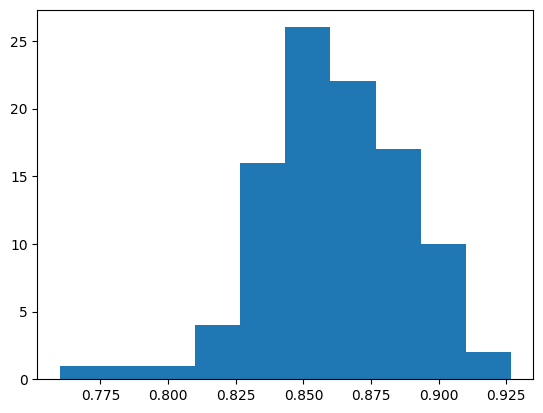

In [ ]:
scores = []

clf = RandomForestClassifier(random_state=111, max_depth=20, max_features='sqrt',n_estimators=500, min_samples_leaf=2)

for _ in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

plt.hist(scores)

The statsitics of the predictive accuracy for the test sets in cross-validation:

In [15]:
print(f"The mean accuracy: {np.mean(scores)}"
      + "\n"
      + f"The standard deviation: {np.std(scores)}")

The mean accuracy: 0.8600666666666666
The standard deviation: 0.027121045538679205


We obtained practically the same accuracy as with the untuned random forrest model. 

<br/>   <a id='section4'></a>

### <ins>Data evaluation III. : Checking the uncertainity introduced by both the training process and test set prediction using repeated nested cross-validation

The model obtained through repeated cross-validation may be considered as the final model. However, we should investigate the uncertainity caused by the hyperparameters tuning process and the testing on different test sets. For that we can use repeated nested cross-validation. To get the picture about the uncertainity of the tuning process we are using repeated cross-validation in the inner loop, and repeated cross-validation in the outer loop to see the uncertainity caused by different train-test splits.

In [19]:
from sklearn.metrics import accuracy_score

param_grid = {
    "n_estimators": [100, 300, 500],
    "max_features": ["sqrt", None],
    "max_depth": [10, 20],
    "min_samples_leaf": [1, 2, 4, 10],
}

best_params = []
best_pred_scores = []

outer_cv = RepeatedKFold(n_repeats=3, n_splits=5, random_state=111)
inner_cv = RepeatedKFold(n_repeats=2, n_splits=3, random_state=111)

for train, test in outer_cv.split(X, y):
    X_train, y_train = X.iloc[train, :], y[train]
    X_test, y_test = X.iloc[test, :], y[test]
    clf = RandomForestClassifier(random_state=111)
    grid_search = GridSearchCV(
    estimator=clf, param_grid=param_grid, cv=inner_cv, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    clf_fin = grid_search.best_estimator_
    clf_fin.fit(X_train, y_train)
    y_test_pred = clf_fin.predict(X_test)
    best_pred_scores.append(accuracy_score(y_test, y_test_pred))
    best_params.append(grid_search.best_estimator_.get_params())

The statsitics of the predictive accuracy for unseen test sets:

In [20]:
print(
    f"Mean is {np.mean(best_pred_scores)}"
    + "\n"
    + f"Standard deviation is {np.std(best_pred_scores)}"
)

Mean is 0.8619179716629382
Standard deviation is 0.01771475247750567


The uncertainity is quite small which implies, that the model building method including the data splitting and the selection of the "best model" in each split is robust and the differences between the power of the found best models are negligible. 

The frequency of the found "best" hyperparameter sets:

In [57]:
best_params_list = []
for set in best_params:
    best_params_list.append([set.get(key) for key in ["n_estimators", "max_features","max_depth","min_samples_leaf"]])
pd.DataFrame(best_params_list, columns=["n_estimators", "max_features","max_depth","min_samples_leaf"]).value_counts()

n_estimators  max_features  max_depth  min_samples_leaf
500           sqrt          10         1                   4
300           sqrt          20         1                   2
100           sqrt          10         10                  1
                            20         2                   1
                                       1                   1
300           sqrt          10         4                   1
                                       2                   1
                            20         2                   1
500           sqrt          10         10                  1
                            20         1                   1
                                       2                   1
Name: count, dtype: int64

The nested cross-validation showed that the uncertainity of the training process is sufficiently small, and models with godd predictive accuracy can be obtained during the tuning. The nested cross-validation found most frequently the settings of n_estimators = 500, max_features = 'sqrt', max_depth = 10, and min_samples_leaf = 1. 

Let's find the features that contribute to the classification of the respond the most using the parameter values that are the most frequently found in nested cross validation:

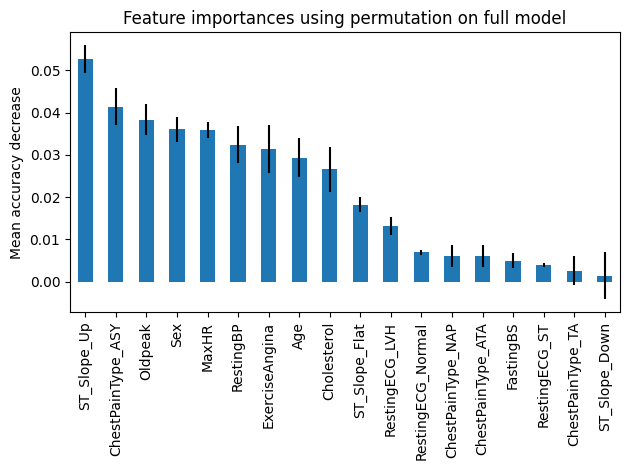

In [58]:
from sklearn.inspection import permutation_importance

clf = RandomForestClassifier(random_state=111, max_depth=10, max_features='sqrt', n_estimators=500, min_samples_leaf=1)
clf.fit(X,y)
result = permutation_importance(
    clf, X, y, n_repeats=100, random_state=111, n_jobs=-1
)
forest_importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


Let's use only the first 11 features with the most influence, and see if we can achieve similar predictive accuracy as before using nested cross validation:

In [75]:
X_reduced = X[forest_importances[0:11].index]

param_grid = {
    "n_estimators": [100, 300, 500],
    "max_features": ["sqrt", None],
    "max_depth": [10, 20],
    "min_samples_leaf": [1, 2, 4, 10],
}

best_params = []
best_pred_scores = []

outer_cv = RepeatedKFold(n_repeats=3, n_splits=5, random_state=111)
inner_cv = RepeatedKFold(n_repeats=2, n_splits=3, random_state=111)

for train, test in outer_cv.split(X_reduced, y):
    X_train, y_train = X_reduced.iloc[train, :], y[train]
    X_test, y_test = X_reduced.iloc[test, :], y[test]
    clf = RandomForestClassifier(random_state=111)
    grid_search = GridSearchCV(
    estimator=clf, param_grid=param_grid, cv=inner_cv, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    clf_fin = grid_search.best_estimator_
    clf_fin.fit(X_train, y_train)
    y_test_pred = clf_fin.predict(X_test)
    best_pred_scores.append(accuracy_score(y_test, y_test_pred))
    best_params.append(grid_search.best_estimator_.get_params())

The statsitics of the predictive accuracy for unseen test sets:

In [76]:
print(
    f"Mean is {np.mean(best_pred_scores)}"
    + "\n"
    + f"Standard deviation is {np.std(best_pred_scores)}"
)

Mean is 0.865950782997763
Standard deviation is 0.018158339341737873


Similar results are obtained as before, when every feature were used. This suggest, that using only the 11 most influental features does not result in information loss. Let's see the most frequently found parameter settings:

In [77]:
best_params_list = []
for set in best_params:
    best_params_list.append([set.get(key) for key in ["n_estimators", "max_features","max_depth","min_samples_leaf"]])
pd.DataFrame(best_params_list, columns=["n_estimators", "max_features","max_depth","min_samples_leaf"]).value_counts()

n_estimators  max_features  max_depth  min_samples_leaf
500           sqrt          10         1                   3
300           sqrt          20         1                   2
500           sqrt          20         1                   2
100           sqrt          20         2                   1
                            10         10                  1
                                       4                   1
300           sqrt          10         1                   1
                            20         2                   1
                            10         2                   1
500           sqrt          10         2                   1
                            20         2                   1
Name: count, dtype: int64

The same hyperparameter settings were found to be the most frequent as before. Let's use this hyperparameter set to find the final predictive power of our model:

(array([ 1.,  0.,  5., 16., 20., 28., 17.,  6.,  5.,  2.]),
 array([0.79333333, 0.80733333, 0.82133333, 0.83533333, 0.84933333,
        0.86333333, 0.87733333, 0.89133333, 0.90533333, 0.91933333,
        0.93333333]),
 <BarContainer object of 10 artists>)

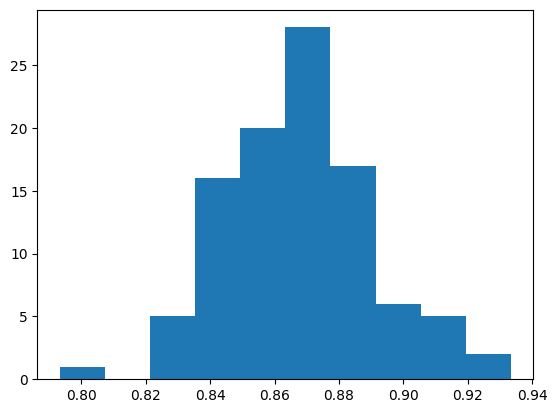

In [78]:
scores = []

clf = RandomForestClassifier(random_state=111, max_depth=20, max_features='sqrt',n_estimators=500, min_samples_leaf=2)

for _ in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2)

    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

plt.hist(scores)

In [79]:
print(f"The mean accuracy: {np.mean(scores)}"
      + "\n"
      + f"The standard deviation: {np.std(scores)}")

The mean accuracy: 0.8674
The standard deviation: 0.022684208898115298


The model works well both for description and prediction of the data. Although it does not differ from the untuned model regarding its power, we achieved to reduce the number of independent variables required to fit a model with the same power.